In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import floor
# Benford's law can be calculated on any base besides 10, change it here!
base = 13

In [2]:
def first_digit(num):
    n = np.math.log(num, base)
    return floor(pow(base, n - floor(n)))

In [3]:
import requests
url = 'https://county.milwaukee.gov/EN/County-Clerk/Off-Nav/Election-Results/Election-Results-Fall-2020'

In [4]:
headers = {'User-Agent': "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
           "(KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"}
r = requests.get(url, headers=headers)

In [5]:
from bs4 import BeautifulSoup as bs

In [6]:
bs_data = bs(r.text, 'html.parser')

In [7]:
precincts = bs_data.findAll('table', {'class': 'precinctTable'})

In [8]:
# presidential election on 1st precinctTable
precinct = precincts[1]
dataset = pd.DataFrame()

# split by table rows
for tr in precinct.find_all('tr'):
    
    lines = tr.text.split('\n')
    
    # second column is ward name
    ward_name = lines[2]

    # Header line
    if ward_name == "Ward":
        for line in lines[3:]:
            dataset[line] = 0    
    else:
        
        # append row
        new_row = {}
        for i in range(len(dataset.columns)):
            col = dataset.columns[i]
            value = lines[3+i]
            new_row[col] = value

        dataset = dataset.append(pd.Series(new_row, name=ward_name))


In [9]:
unstacked_data = dataset.unstack().reset_index().rename(
columns={0: 'count', 'level_0': 'candidate', 'level_1': 'ward'}
)

In [10]:
unstacked_data.head()

,candidate,ward,count
0,Joseph R. Biden / Kamala D. Harris,City of Milwaukee Ward 1,974
1,Joseph R. Biden / Kamala D. Harris,City of Milwaukee Ward 2,323
2,Joseph R. Biden / Kamala D. Harris,City of Milwaukee Ward 3,718
3,Joseph R. Biden / Kamala D. Harris,City of Milwaukee Ward 4,1257
4,Joseph R. Biden / Kamala D. Harris,City of Milwaukee Ward 5,660


Text(0.5, 0.98, 'Milwaukee')

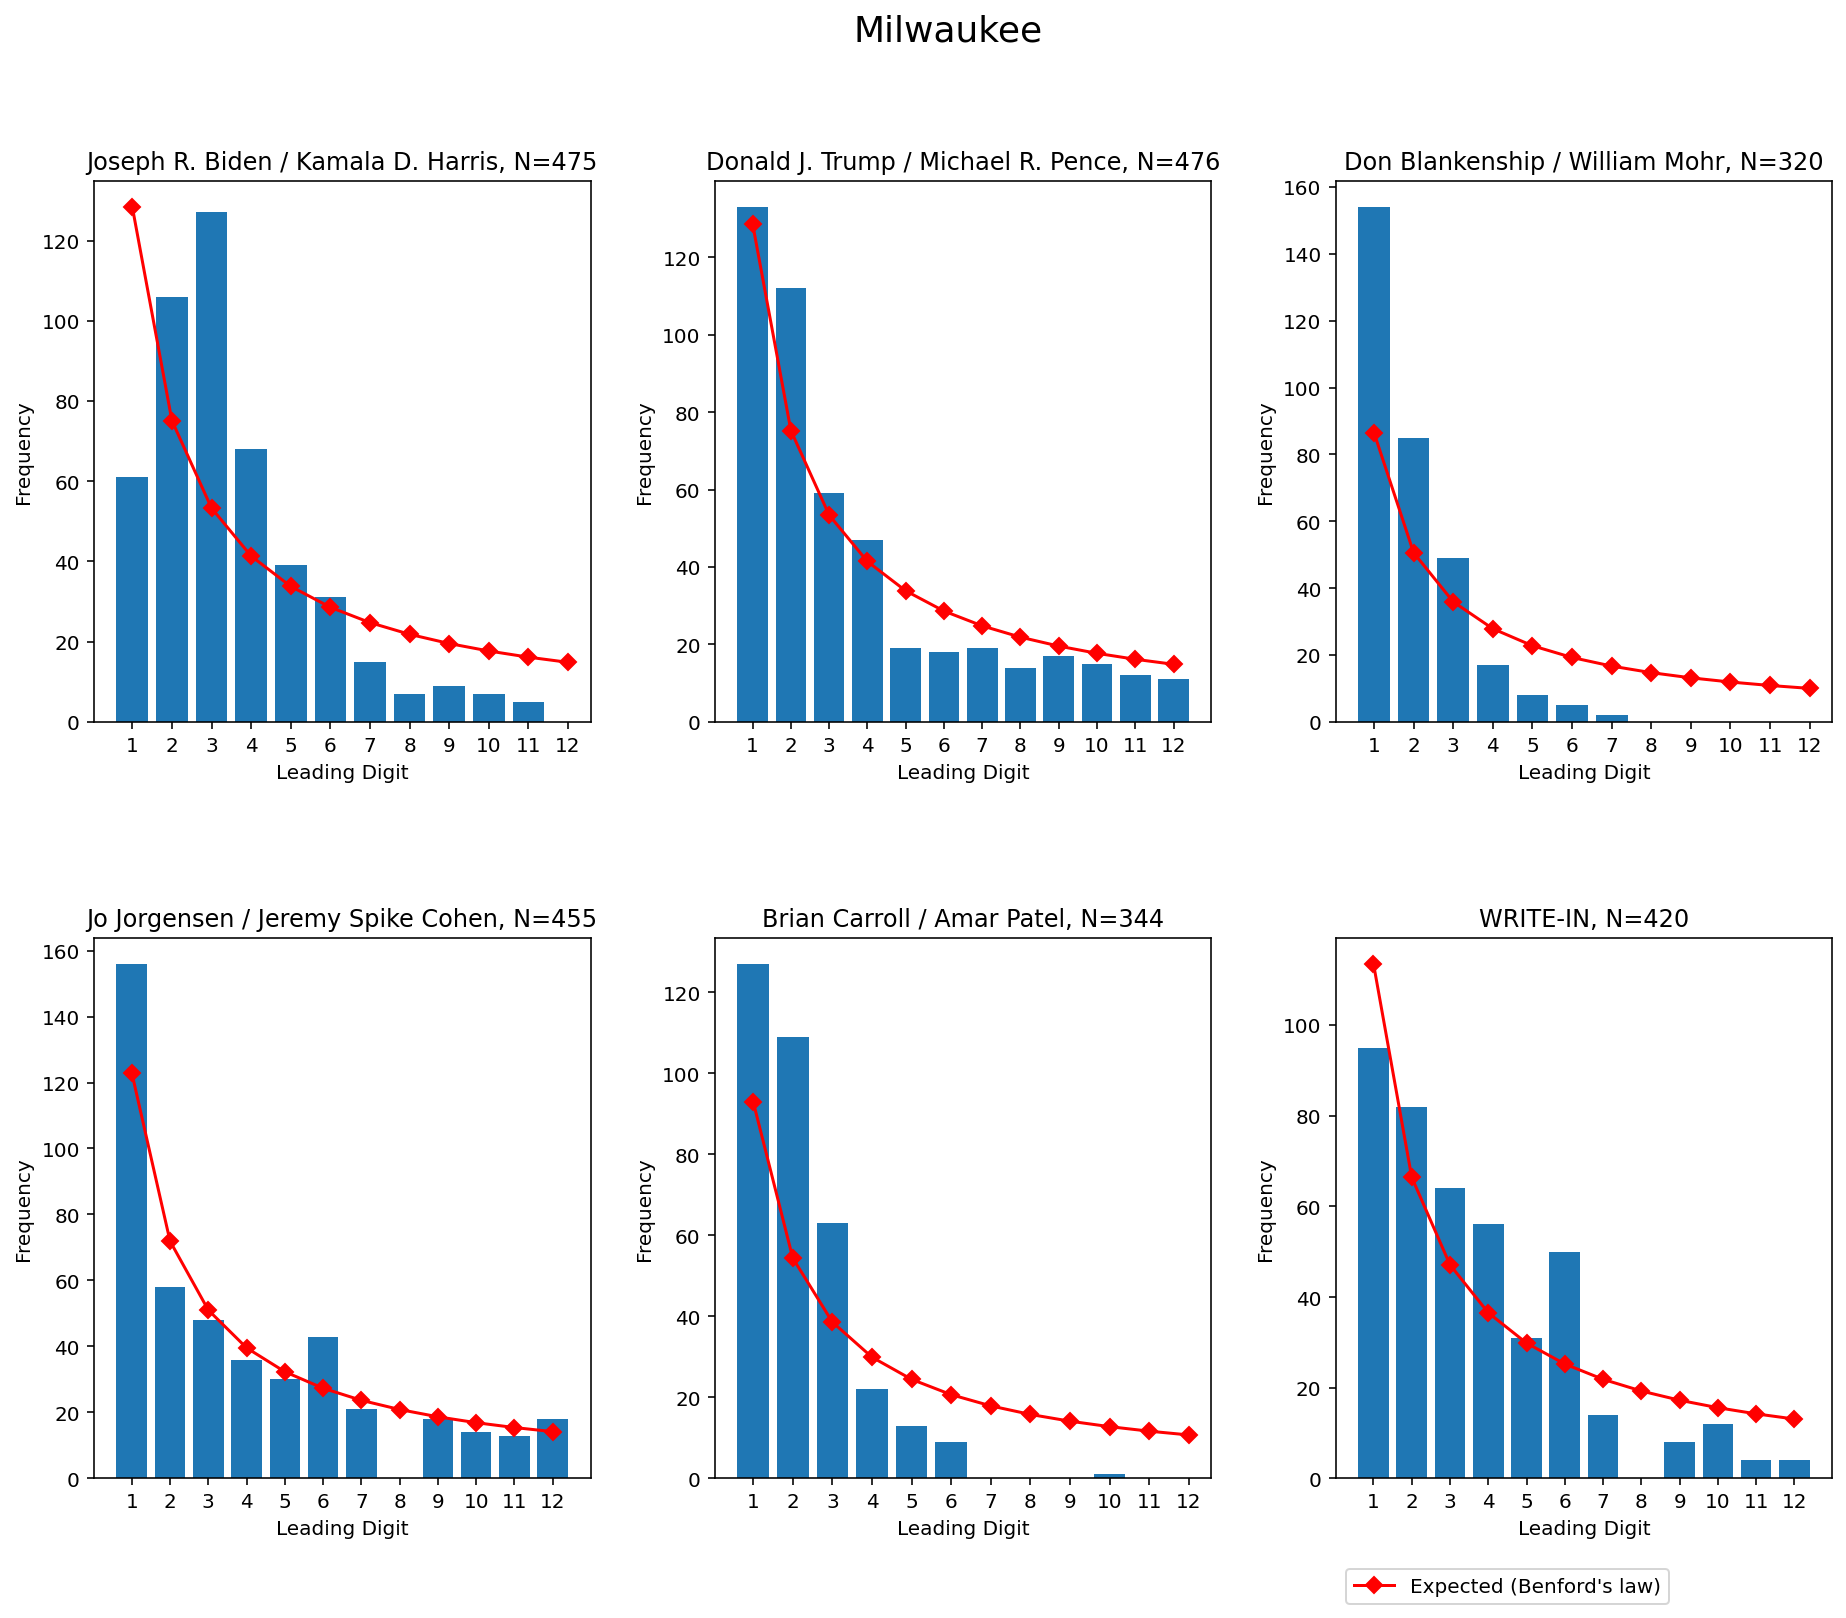

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(16, 12))
fig.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])
plt.subplots_adjust(hspace=0.4, wspace=0.25)
    
axs = np.array(axs).flatten()
candidates = unstacked_data.candidate.unique()

# benford's law
digit = np.arange(1, base)

for i in range(len(axs)):

    ax = axs[i]
    candidate = candidates[i]
    
    N = len(dataset[dataset[candidate].astype(int) > 0])
    expected = np.log(1 + 1/digit) / np.log(base) * N
        
    cur_data = unstacked_data
    cur_data = cur_data.groupby(['candidate', 'ward']).sum()
    data = cur_data.loc[candidate]['count'].astype(int)
    data = data[data > 0]
    digits = data.apply(first_digit)
    
    v = digits.value_counts()
    ax.bar(v.index, v.values)
    ax.set_xticks(range(1, base))
    
    ax.plot(digit, expected, marker='D', color='red', label='Expected (Benford\'s law)')
    
    ax.set_title("%s, N=%d" % (candidate, N))
    ax.set_xlabel("Leading Digit")
    ax.set_ylabel("Frequency")

plt.legend(loc=3, bbox_to_anchor=(0.0, -0.25))
plt.suptitle("Milwaukee", fontsize=18)
    